In [1]:
!pip install pyEDM 
!pip install torchcde
# !pip install gdown  # чтобы скачать данные с гугл диска

from IPython.display import clear_output
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy.random as npr
import pandas as pd
import pyEDM   # реализация CCM
import torchdiffeq
clear_output()

# подготовка данных

Методы будут исследованы на двух датасетах - игрушечном и реальном

Игрушечный датасет состоит из пар временных рядов, которые зависят друг от друга:

$$X(t + 1) = X(t)[r_x - r_x X_t - \beta_{x,y}Y_t]$$
$$Y(t + 1) = Y(t)[r_y - r_y Y_t - \beta_{y,x}X_t]$$

Зависимость взята из статьи о CCM, как пример зависимости с которой CCM справляется лучше чем другие методы.

Реальные данные - данные с акселерометра и гироскопа телефона при выполнении действий.


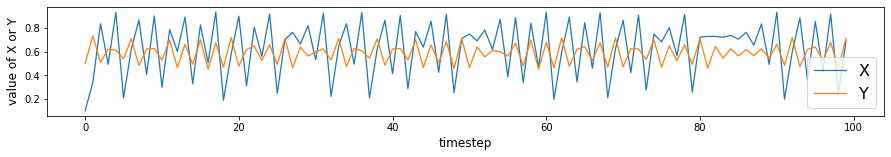

In [ ]:
#  toy dataset
def generate(A, B, r, beta):
    return A*(r - r*A - beta * B)

t = 1000 # time steps
r_x =  3.8
r_y =  3.

B_xy = 0.06 # effect on x given y (effect of y on x)
B_yx = 0.3  # effect on y given x (effect of x on y)

X0 = 0.1
Y0 = 0.5

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = generate(X[-1], Y[-1], r_x, B_xy)
    Y_ = generate(Y[-1], X[-1], r_y, B_yx)    
    X.append(X_)
    Y.append(Y_)  

X_toy = np.array(X).T
Y_toy = np.array(Y).T

X_toy =pd.DataFrame(np.array([np.arange(0, len(X_toy)), X_toy]).T, columns=["time", "x"])
Y_toy =pd.DataFrame(np.array([np.arange(0, len(Y_toy)), Y_toy]).T, columns=["time", "y"])

plt.figure(figsize=(15,2))
max_t = 100
plt.plot(X_toy['x'][:max_t], linewidth=1.25, label='X')
plt.plot(Y_toy['y'][:max_t], linewidth=1.25, label='Y')
plt.xlabel('timestep', size=12)
plt.ylabel('value of X or Y', size=12)
plt.legend(prop={'size': 16})

In [2]:
#  zip file link
# https://drive.google.com/file/d/1IFgOpn0MF8EP0W4jsaOWKYLCx0spsu1W/view?usp=sharing
# !pip install gdown
import gdown
url = 'https://drive.google.com/uc?id=1IFgOpn0MF8EP0W4jsaOWKYLCx0spsu1W'
output = 'dataset.zip'
gdown.download(url, output, quiet=False)

!unzip dataset.zip
clear_output()

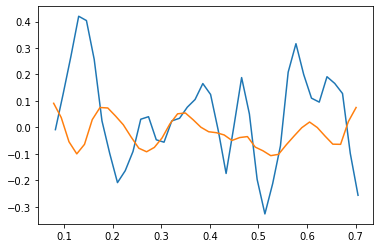

In [3]:
# так как метод непараметрический, рассмотрим некоторый кусок из наблюдений
X_data = pd.read_csv("./unzipped/5/Accelerometer.csv")
Y_data = pd.read_csv("./unzipped/5/Gyroscope.csv")

plt.plot(X_data['seconds_elapsed'][:40], X_data['x'][:40])
plt.plot(Y_data['seconds_elapsed'][:40], Y_data['x'][:40])

Так как данные сняты со сдвигом (на устройстве приложения не могут записать время в один и тот же момент) нужно ввести структуру для получения измерений с одинаковым временем

Рассмотрим линейную и кубическую интерполяцию для решения этой проблемы

In [4]:
import torchcde as cde
import torch
def get_interpolation(data, linear = True):
    data_times = torch.tensor(np.array(data["seconds_elapsed"]))
    data_linear = torch.tensor(np.array(data[["x", "y", "z"]]))
    if linear:
        data_coeffs = cde.linear_interpolation_coeffs(data_linear, data_times)
        data_interploation = cde.LinearInterpolation(data_coeffs, data_times)
    else:  # else we use qubic interpolation
        data_coeffs = cde.natural_cubic_spline_coeffs(data_linear, data_times)
        data_interploation = cde.CubicSpline(data_coeffs, data_times)
    return data_interploation

def align_by_time(X_data, Y_data, t = None, linear = True):
    X_interpolation = get_interpolation(X_data, linear)
    Y_interpolation = get_interpolation(Y_data, linear)
    if t is None:
        t = X_interpolation.grid_points
    align_x = torch.vstack([X_interpolation.evaluate(t_i) for t_i in t])
    align_y = torch.vstack([Y_interpolation.evaluate(t_i) for t_i in t])
    rez = torch.hstack([t.reshape(-1, 1), align_x, align_y]).numpy()
    rez = pd.DataFrame(rez, columns = ["time", "A:x", "A:y", "A:z", "G:x", "G:y", "G:z"])
    return rez

real_data = align_by_time(X_data, Y_data)

"time", "A:x", "A:y", "A:z", "G:x", "G:y", "G:z"

здесь A:  --- акселерометр $\ \ \ \ \ \ $G: --- гироскоп

Сделаем структуру для удобного считывания и подачи в модель


In [5]:
import numpy.random as npr
## batch_size будет = 1 , так как torchdiffeq работает только так
def gen_batch(batch_size, Emb_size, time_len, dataset_embeddings, time):
    data_full_len = time.shape[0]
    starts = npr.randint(Emb_size, data_full_len - time_len - 1, batch_size)
    # print(starts, time_len)
    datas = [dataset_embeddings[starts[i]: starts[i] + time_len] for i in range(batch_size)]
    datas = torch.tensor(np.array(datas)).permute(0, 2, 1)
    times = [time[starts[i]: starts[i] + time_len] for i in range(batch_size)]
    times = torch.tensor(np.array(times)).unsqueeze(1)
    return datas, times
def gen_data(count, batch_size, emb_size, time_len, columns, dataset):
    time = dataset["time"]
    dataset_embeddings = pyEDM.Embed(dataFrame = dataset, E = emb_size, columns = columns)
    for _ in range(count):
        yield gen_batch(batch_size, emb_size, time_len, dataset_embeddings, time)

In [6]:
import numpy.random as npr
import numpy.random as npr
## batch_size будет = 1 , так как torchdiffeq работает только так
def gen_batch_timedeltas(batch_size, Emb_size, time_len, dataset_embeddings, time):
    """
    в качестве метки времени выступает изменение времени до следующего измерения
    Также возвращает целевое значение после эволюции по времени
    """
    time_len = time_len + 1
    data_full_len = time.shape[0]
    starts = npr.randint(Emb_size, data_full_len - time_len - 1, batch_size)
    
    # print(starts, time_len)
    datas = [dataset_embeddings[starts[i]: starts[i] + time_len] for i in range(batch_size)]
    datas = torch.tensor(np.array(datas)).permute(0, 2, 1)
    times = [(np.array(time[starts[i] + 1: starts[i] + time_len + 1])- np.array(time[starts[i]: starts[i] + time_len])) for i in range(batch_size)]
    times = torch.tensor(np.array(times)).unsqueeze(1)
    return datas[..., :-1], datas[...,-1], times[..., :-1]
def gen_data_timedeltas(count, batch_size, emb_size, time_len, columns, dataset):
    time = dataset["time"]
    dataset_embeddings = pyEDM.Embed(dataFrame = dataset, E = emb_size, columns = columns)
    for _ in range(count):
        yield gen_batch_timedeltas(batch_size, emb_size, time_len, dataset_embeddings, time)

In [7]:
for data, val, times in gen_data_timedeltas(2, 2, 3, 10, "A:x", real_data):
    print(times)
    print(data.shape, val.shape, times.shape)

tensor([[[0.0160, 0.0160, 0.0160, 0.0160, 0.0160, 0.0160, 0.0160, 0.0160,
          0.0160, 0.0160]],

        [[0.0160, 0.0160, 0.0160, 0.0160, 0.0160, 0.0160, 0.0160, 0.0160,
          0.0160, 0.0160]]], dtype=torch.float64)
torch.Size([2, 3, 10]) torch.Size([2, 3]) torch.Size([2, 1, 10])
tensor([[[0.0160, 0.0160, 0.0160, 0.0160, 0.0160, 0.0160, 0.0160, 0.0160,
          0.0160, 0.0160]],

        [[0.0160, 0.0160, 0.0160, 0.0160, 0.0160, 0.0160, 0.0160, 0.0160,
          0.0160, 0.0160]]], dtype=torch.float64)
torch.Size([2, 3, 10]) torch.Size([2, 3]) torch.Size([2, 1, 10])


# подготовка и обучение модели

Обработка временного ряда производится с помощью ODE-RNN сети

модель принимает embedding и как в базовой модели в качестве входа.

И теперь скрытое состояние RNN используется как многообразие для применения методов Сугихары

P.S. это variational ODERNN , линейный ODERNN ниже

## variational ODE

In [ ]:
import torch.nn as nn
import torch
class RNN(nn.Module):
    # gets input of shape (1, batch_size, input_dim)
    def __init__(self, input_dim, hidden_dim, num_layers = 1):
        super(RNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.rnn = nn.GRU(input_dim, hidden_dim, num_layers = num_layers)
    def forward(self, x, h):
        return self.rnn(x, h)

class ODE_func(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        # для начала испоьзуем линейное уравнение
        super(ODE_func, self).__init__()
        self.input_dim = input_dim
        self.layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ELU(inplace = True),
            nn.Linear(hidden_dim, input_dim)
        )
    def forward(self, t, x):
        return self.layer(x)

class NeuralODE(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NeuralODE, self).__init__()
        self.input_dim = input_dim
        self.func = ODE_func(input_dim, hidden_dim)
    def forward(self, x, t, return_whole_sequence = False):
        out = torchdiffeq.odeint_adjoint(self.func, x, t.squeeze())
        if return_whole_sequence:
            return out
        return out[-1]

class ODE_RNNencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers = 1, return_hidden = False):
        ## input_dim == output_dim
        super(ODE_RNNencoder, self).__init__()
        self.return_hidden = return_hidden
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.rnn = RNN(input_dim, hidden_dim, num_layers)
        self.ode = NeuralODE(hidden_dim * num_layers, hidden_dim * num_layers)
        self.hid2lat = nn.Linear(hidden_dim * num_layers, 2 *latent_dim)
    def forward(self, x, t):
        #x.shape = (batch_size, input_size, time_steps)
        #t.shape = (batch_size, 1, time_steps)
        #h.shape = (num_layers, batch_size, hidden_dim)
        assert len(x.shape) == 3 
        batch_size = x.shape[0] 
        h = torch.zeros(self.num_layers, batch_size, self.hidden_dim).float()
        h = h.to(next(self.parameters()).device)
        x = x.flip((2,))
        t = t.flip((2,))
        h_s = []
        for i in range(x.shape[2] - 1):
            x_i = x[..., i ].unsqueeze(0)
            _, h = self.rnn(x_i, h)
            h = h.permute(1, 0 , 2).reshape(batch_size, self.hidden_dim * self.num_layers)
            h = self.ode(h, t[...,i: i + 2])
            h = h.reshape(batch_size, self.num_layers, self.hidden_dim).permute(1, 0, 2)
            if self.return_hidden:
                h_s.append(h.detach())
        h = h.permute(1, 0 , 2).reshape(batch_size, self.hidden_dim * self.num_layers)
        h = self.hid2lat(h) ## shape: (batch_size, 2 * latent_dim)
        mu = h[:, :self.latent_dim]
        log_sigma = h[:, self.latent_dim:]
        return mu, log_sigma, h_s 

class ODEdecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.ode = NeuralODE(latent_dim, 2 * latent_dim)
        self.lat2in = nn.Linear(latent_dim, input_dim)
    def forward(self, z, t):
        z = self.ode(z, t, return_whole_sequence = True)
        z = self.lat2in(z)
        return z

class ODERNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers = 1):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.latend_dim = latent_dim
        self.encoder = ODE_RNNencoder(input_dim, hidden_dim, latent_dim, num_layers)
        self.decoder = ODEdecoder(input_dim, hidden_dim, latent_dim)
    def forward(self, x, t, MAP = False):
        mu, log_sigma, _ = self.encoder(x, t)
        if MAP:
            z = mu
        else:
            z = mu + torch.randn_like(mu) * torch.exp(0.5 * log_sigma)
        x_s = self.decoder(z, t)
        x_s = x_s.permute(1,2,0)
        return x_s, mu, log_sigma
    def decode_with_hidden(self, x, t):
        self.eval()
        self.encoder.return_hidden = True
        mu, log_sigma, h_s = self.encoder(x, t)
        self.encoder.return_hidden = False        
        return mu, log_sigma, h_s
    def decode(self, x, t):
        self.eval()
        mu, log_sigma, _ = self.encoder(x, t)
        return mu, log_sigma


class KL_loss(nn.Module):
    def __init__(self, unnealing = 0.99):
        self.unnealing = unnealing
        self.unneal_coef = 1.
        super().__init__()
    def forward(self, mu, log_sigma):
        self.unneal_coef *= self.unnealing 
        return self.unneal_coef * (-0.5) * torch.sum(1 + log_sigma - mu**2 - torch.exp(log_sigma), -1)

Тренировочная функция

In [ ]:
import os
os.chdir("drive/MyDrive/Colab Notebooks/m1p")

baseline.ipynb  dataset.zip                     MFSP.ipynb  unzipped/
datasets/       main_idea_implementation.ipynb  models/


In [ ]:
from tqdm import tqdm

def train(net, dataloader, kl_annealing = 0.99, savepath = None, save_every = 100):
    fig, axs = plt.subplots(1 ,2 , figsize = (10 , 5))
    p = display(fig, display_id = True) 
    axs[0].set_title("L2")
    axs[1].set_title("KL")
    L2 = []
    KL = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    optim = torch.optim.Adamax(net.parameters(), lr = 0.01, weight_decay = 0.999)
    
    kl_loss_f = KL_loss(kl_annealing)
    l2_loss_f = torch.nn.MSELoss()
    # тренируем не по эпохам, а по итерациям
    for i, tmp in tqdm(enumerate(dataloader)):
        data, time = tmp
        data = data.float().to(device)
        time = time.float().to(device)
        data_, mu, log_sigma = net(data, time)
        kl_loss = kl_loss_f(mu, log_sigma)
        l2_loss = l2_loss_f(data, data_)
        loss = kl_loss + l2_loss
        optim.zero_grad()
        loss.backward()
        optim.step()

        L2.append(l2_loss.detach().item())
        KL.append(kl_loss.detach().item())
        if i % 5 == 0:
            axs[0].plot(L2)
            axs[1].plot(KL)
            p.update(fig)
        if savepath is not None and i % save_every == 0 and i > 0:
            torch.save(net.state_dict(), f"{savepath}_{i}.mod")


Проверим работоспособность модели на одном временном ряде

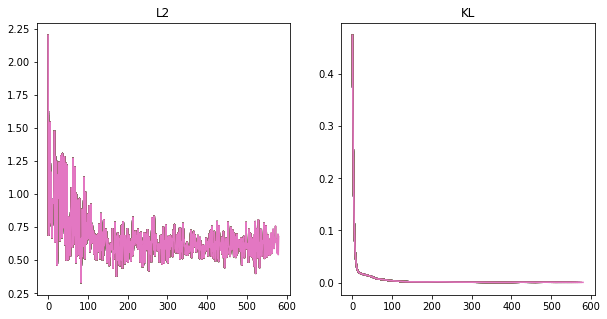

583it [04:14,  2.29it/s]


KeyboardInterrupt: ignored

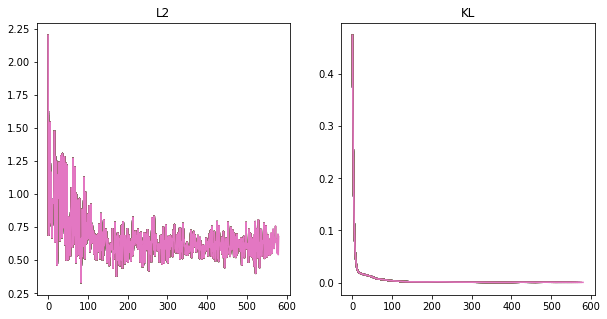

In [ ]:
net = ODERNN(6, 8, 10, 2)
def one_dataloader():
    data, time = next(gen_data(1, 1, 3, 10,  "A:x A:y", real_data))
    data = data.float()
    time = time.float()
    for i in range(700):
        yield data, time
train(net, one_dataloader(), 1)

видим, что модель быстро переобучается на одном временном ряде, что значит что модель работает правильно.

Теперь обучим модели на данных акселерометра и гироскопа из "./unzipped/5" и посмотрим, как будет работать метод CCM

Для акселерометра размерность погружения = 2

Для гироскопа размерность погружения = 4

(выяснили в baseline)

будем обучать на кусках данных длиной 200 в течение 2000 итераций

In [ ]:
Accelerometer_embed = 2
Gyroscope_embed = 4
hidden_dim = 10
latent_dim = 10

Accelerometer_net = ODERNN(Accelerometer_embed * 3, hidden_dim, latent_dim)
Gyroscope_net = ODERNN(Gyroscope_embed * 3, hidden_dim, latent_dim)

Accelerometer_data = gen_data(500, 1, Accelerometer_embed, 200, "A:x A:y A:z", real_data)
Gyroscope_data = gen_data(201, 1, Gyroscope_embed, 200, "G:x G:y G:z", real_data)

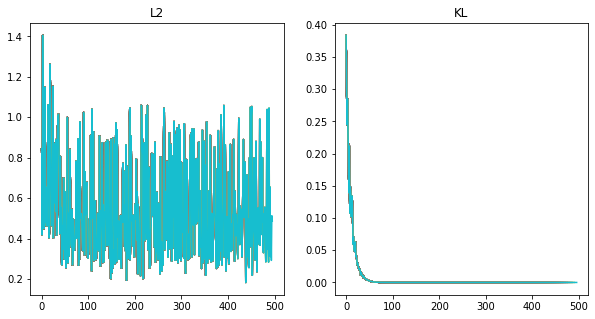

500it [47:39,  5.72s/it]


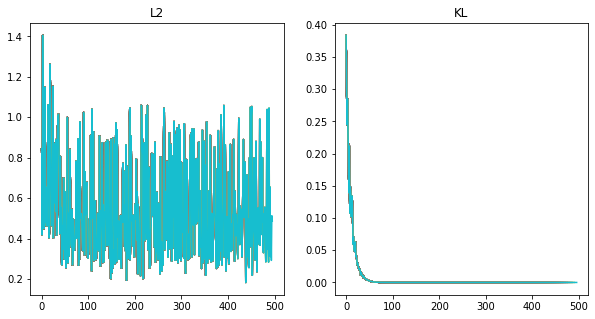

In [ ]:
save_path = "./models/Accelerometer"
train(Accelerometer_net, Accelerometer_data, 1, save_path)

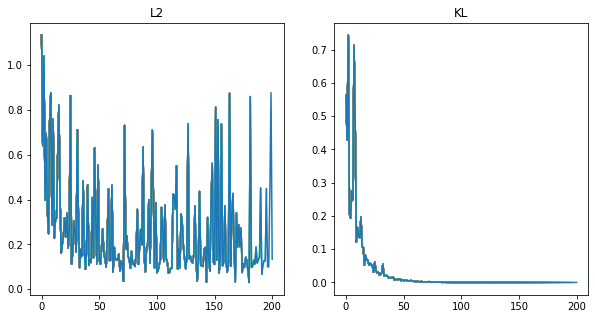

201it [19:43,  5.89s/it]


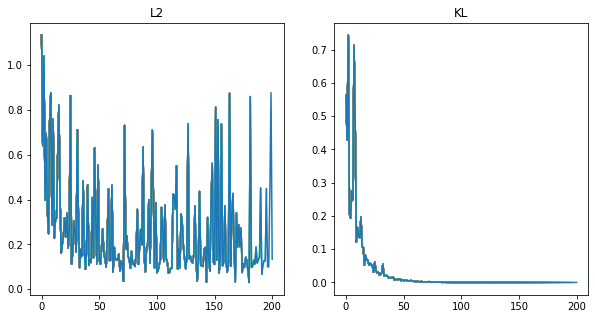

In [ ]:
save_path = "./models/Gyroscope"
train(Gyroscope_net, Gyroscope_data, 1, save_path)

Модели не научились генерировать ряд, но научились их нормализовать

Посмотрим на CCM - score скрытых состояний

In [ ]:
Accelerometer_net = ODERNN(Accelerometer_embed * 3, hidden_dim, latent_dim)
Accelerometer_net.load_state_dict( torch.load("./models/Accelerometer_400.mod"))

Gyroscope_net = ODERNN(Gyroscope_embed * 3, hidden_dim, latent_dim)
Gyroscope_net.load_state_dict( torch.load("./models/Gyroscope_200.mod"))

<All keys matched successfully>

In [ ]:
real_data.shape

(2837, 7)

In [ ]:
Accelerometer_net = ODERNN(Accelerometer_embed * 3, hidden_dim, latent_dim)
Accelerometer_net.load_state_dict( torch.load("./models/Accelerometer_400.mod"))

Gyroscope_net = ODERNN(Gyroscope_embed * 3, hidden_dim, latent_dim)
Gyroscope_net.load_state_dict( torch.load("./models/Gyroscope_200.mod"))

acc_data, acc_time = next(gen_data(1, 1, Accelerometer_embed, 2800, "A:x A:y A:z", real_data))
gyr_data, gyr_time = next(gen_data(1, 1, Gyroscope_embed, 2800, "G:x G:y G:z", real_data))
acc_data, acc_time = acc_data.float(), acc_time.float()
gyr_data, gyr_time = gyr_data.float(), gyr_time.float()

_, _, accelerometer_h = Accelerometer_net.decode_with_hidden(acc_data, acc_time)
_, _, gyroscope_h     = Gyroscope_net.decode_with_hidden(gyr_data, gyr_time)

In [ ]:
acc_h = np.array([accelerometer_h[i].squeeze().numpy() for i in range(len(accelerometer_h))])
gyr_h = np.array([gyroscope_h[i].squeeze().numpy() for i in range(len(gyroscope_h))])
time_ = acc_time.numpy()

In [ ]:
data_ = pd.DataFrame(np.hstack( [time_.squeeze()[:-1].T[:, np.newaxis], acc_h, gyr_h]) , columns = ['time', *[f"A:{i}" for i in range(10)], *[f"G:{i}" for i in range(10)]])         

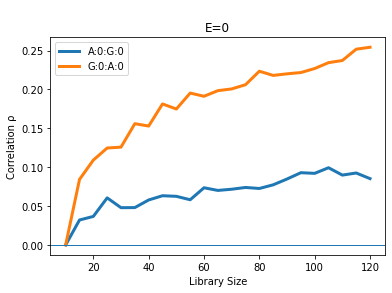

In [ ]:
columns = ' '.join([f"A:{i}" for i in range(10)])
target =  ' '.join([f"G:{i}" for i in range(10)])
tmp = pyEDM.CCM(dataFrame = data_, columns = columns, target = target, embedded= True,libSizes="10 120 5", sample = 100, showPlot = True)

In [ ]:
tmp = pyEDM.SMap(dataFrame = data_, columns = columns, target = target, embedded= True,libSizes="10 120 5", sample = 100, showPlot = True)

TypeError: ignored

## RNNODE

In [8]:
import torch.nn as nn
import torch
class RNN(nn.Module):
    # gets input of shape (1, batch_size, input_dim)
    def __init__(self, input_dim, hidden_dim, num_layers = 1):
        super(RNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.rnn = nn.GRU(input_dim, hidden_dim, num_layers = num_layers)
    def forward(self, x, h):
        return self.rnn(x, h)

class ODE_func(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(ODE_func, self).__init__()
        self.input_dim = input_dim
        self.layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ELU(inplace = True),
            nn.Linear(hidden_dim, input_dim)
        )
    def forward(self, t, x):
        return self.layer(x)

class NeuralODE(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NeuralODE, self).__init__()
        self.input_dim = input_dim
        self.func = ODE_func(input_dim, hidden_dim)
    def forward(self, x, t, return_whole_sequence = False):
        t = t.squeeze()
        batch_size = x.shape[0]
        device = next(self.parameters()).device
        
# пока действуем в предположении, что времена одинаковы
        out = torchdiffeq.odeint_adjoint(self.func, x, torch.tensor([0, t[0]]).to(device))
        #t.shape = (batch_size)
        # в качестве t подаются времена на которые нужно эволюционировать каждый элемент батча
        # поэтому добавляем к временам 0, сортируем по delta_t и применяем то что было у ментора
        # out.shape = (batch_size, batch_size, hidden_dim)
        
        # sorter_struct = zip(list(range(batch_size)), x, t)
        # sorter_struct = sorted(sorter_struct, key = lambda key_ : key_[2])
        # x_ = torch.vstack([sorter_struct[i][1] for i in range(batch_size)])
        # x_ = x_.to(device)
        # t_ = torch.tensor([0., *[sorter_struct[i][2] for i in range(batch_size)]])
        # t_ = t_.to(device)
        # print(t)
        # print(t_)
        
        # out.shape = (batch_size + 1, batch_size, hidden_dim)
        #в нулевой координате содержится X_ не интегрированный. Он нам не нужен
        
        # out = torchdiffeq.odeint_adjoint(self.func, x_, t_)
        # out = out[1:]
        # out = torch.diagonal(out).T
        
        # теперь нужно восстановить порядок элементов батча. Это делатся по индексам в sorter_struct
        
        # sorter_struct = zip([sorter_struct[i][0] for i in range(batch_size)], out)
        # sorter_struct = sorted(sorter_struct, key = lambda key_: key_[0])
        # out = torch.vstack([sorter_struct[i][1] for i in range(batch_size)])
        # out = out.to(device)
        
        if return_whole_sequence:
            return out
        return out[-1]

class ODE_RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers = 1, return_hidden = False):
        ## input_dim == output_dim
        super(ODE_RNN, self).__init__()
        self.return_hidden = return_hidden
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.rnn = RNN(input_dim, hidden_dim, num_layers)
        self.ode = NeuralODE(hidden_dim * num_layers, hidden_dim * num_layers)
        self.hid2inp = nn.Linear(hidden_dim * num_layers, input_dim)
    def forward(self, x, t):
        #x.shape = (batch_size, input_size, time_steps)
        #t.shape = (batch_size, 1, time_steps)
        #h.shape = (num_layers, batch_size, hidden_dim)
        assert len(x.shape) == 3 
        batch_size = x.shape[0] 
        h = torch.zeros(self.num_layers, batch_size, self.hidden_dim).float()
        h = h.to(next(self.parameters()).device)
        h_s = []
        for i in range(x.shape[2]):
            x_i = x[..., i ].unsqueeze(0)
            x_i, h = self.rnn(x_i, h)        
            h = h.permute(1, 0 , 2).reshape(batch_size, self.hidden_dim * self.num_layers)
            h = self.ode(h, t[...,i])
            h = h.reshape(batch_size, self.num_layers, self.hidden_dim).permute(1, 0, 2)
            if self.return_hidden:
                h_s.append(h.detach())
        out = self.hid2inp(h).squeeze()
        return out, h_s 

In [82]:
Accelerometer_embed = 2
Gyroscope_embed = 4
hidden_dim = 10
latent_dim = 10

Accelerometer_net = ODE_RNN(Accelerometer_embed * 3, hidden_dim, latent_dim)
Gyroscope_net = ODE_RNN(Gyroscope_embed * 3, hidden_dim, latent_dim)

Accelerometer_data = gen_data_timedeltas(500, 3, Accelerometer_embed, 200, "A:x A:y A:z", real_data)
Gyroscope_data = gen_data_timedeltas(500, 3, Gyroscope_embed, 200, "G:x G:y G:z", real_data)


In [122]:

Accelerometer_net = ODE_RNN(Accelerometer_embed * 3, hidden_dim, latent_dim)
x_s, h_s = Accelerometer_net(data, time)
print(x_s.shape)

torch.Size([3, 6])


Посмотрим, как быстро сетка переобучается на одном куске данных

In [9]:
from tqdm import tqdm


def train(net, dataloader,test_dataloader, savepath = None, save_every = 100):
    fig, axs = plt.subplots(1 ,2 , figsize = (10 , 5))
    p = display(fig, display_id = True) 
    axs[0].set_title("L2")
    axs[1].set_title("mean_losses")
    L2 = []
    mean_losses = []
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    optim = torch.optim.Adamax(net.parameters(), lr = 0.01, weight_decay = 0.999)
    
    l2_loss_f = torch.nn.MSELoss()
    # тренируем не по эпохам, а по итерациям
    for i, tmp in tqdm(enumerate(dataloader)):
        data, value, time = tmp
        data = data.float().to(device)
        time = time.float().to(device)
        value = value.float().to(device)
        x_s, h_s = net(data, time)
        x_value = x_s[-1]
        l2_loss = l2_loss_f(x_value, value)
        loss = l2_loss
        optim.zero_grad()
        loss.backward()
        optim.step()

        L2.append(l2_loss.detach().item())
        if i % 5 == 0:
            axs[0].plot(L2)
            p.update(fig)
        if savepath is not None and i % save_every == 0 and i > 0:
            torch.save(net.state_dict(), f"{savepath}_{i}.mod")
# testing every 20 goes
        if i % 20 == 0 and i > 0:

            dat_ , lab_, time_ = test_dataloader                
            dat_ = dat_.float().to(device)
            time_ = time_.float().to(device)
            lab_ = lab_.float().to(device)
            x_s, h_s = net(dat_, time_)
            x_value = x_s[-1]
            loss = l2_loss_f(x_value, lab_).detach().item()
            mean_loss = loss / test_size
            mean_losses.append(mean_loss)
            axs[1].plot(mean_losses)
            p.update(fig)



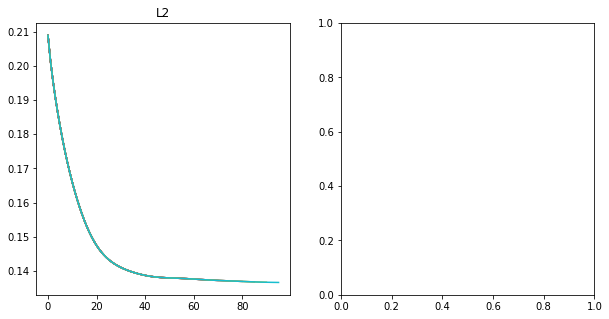

100it [03:07,  1.87s/it]


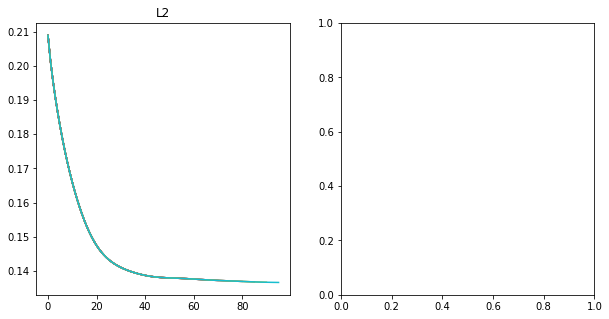

In [126]:
Accelerometer_embed = 2
Gyroscope_embed = 4
hidden_dim = 10
latent_dim = 10

Accelerometer_net = ODE_RNN(Accelerometer_embed * 3, hidden_dim, latent_dim)
Accelerometer_data = gen_data_timedeltas(500, 3, Accelerometer_embed, 200, "A:x A:y A:z", real_data)

def one_dataloader():
    data, val, time = next(Accelerometer_data)
    data = data.float()
    time = time.float()
    for i in range(100):
        yield data, val, time
train(Accelerometer_net, one_dataloader(), 1)

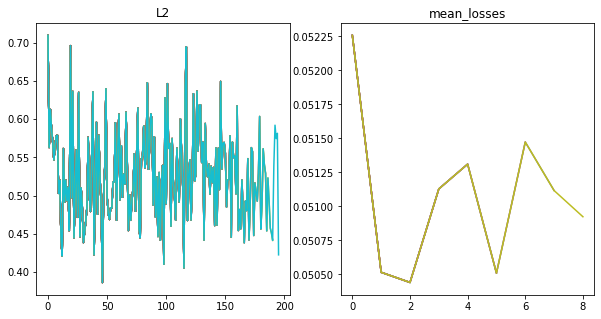

0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([100, 6])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
200it [06:58,  2.09s/it]


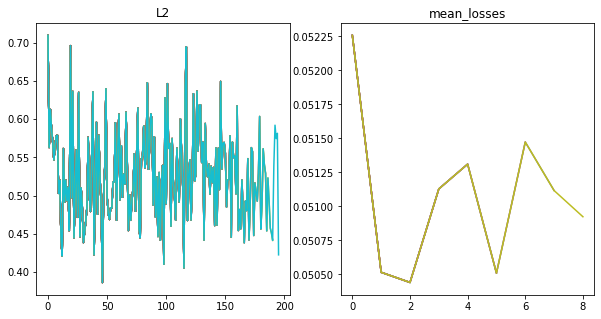

In [10]:
# real_data.shape = (2837, 7)
Accelerometer_embed = 2
Gyroscope_embed = 4
hidden_dim = 10
latent_dim = 10

data_len = 2837
test_size = 3
time_len = 100
train_data = gen_data_timedeltas(200, 100, Accelerometer_embed, time_len,  "A:x A:y A:z", real_data[ : data_len - test_size - time_len ])

text_data = gen_data_timedeltas(200, 100, Accelerometer_embed, time_len,  "A:x A:y A:z", real_data[data_len - test_size - time_len -2:])

Accelerometer_net = ODE_RNN(Accelerometer_embed * 3, hidden_dim, latent_dim)

train(Accelerometer_net, train_data , next(text_data))

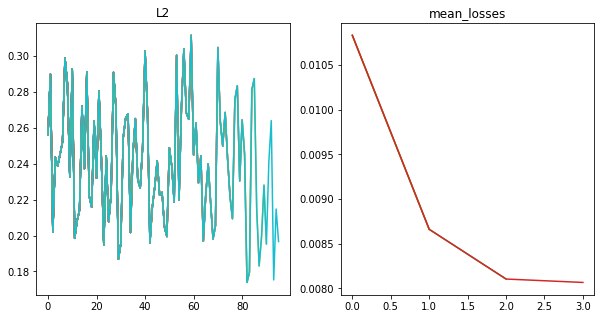

0it [00:00, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([100, 12])) that is different to the input size (torch.Size([12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100it [03:38,  2.18s/it]


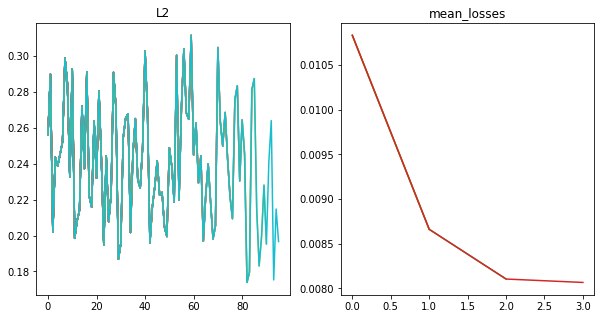

In [15]:
data_len = 2837
test_size = 3
time_len = 100
train_data = gen_data_timedeltas(100, 100, Gyroscope_embed, time_len,  "G:x G:y G:z", real_data[ : data_len - test_size - time_len ])

text_data = gen_data_timedeltas(100, 100, Gyroscope_embed, time_len,  "G:x G:y G:z", real_data[data_len - test_size - time_len - 4:])

Gyroscope_net = ODE_RNN(Gyroscope_embed * 3, hidden_dim, latent_dim)

train(Gyroscope_net, train_data , next(text_data))

In [21]:
ls drive/MyDrive/'Colab Notebooks'/m1p/models

Accelerometer_100.mod  Accelerometer_300.mod  Gyroscope_100.mod
Accelerometer_200.mod  Accelerometer_400.mod  Gyroscope_200.mod


In [22]:
torch.save(Accelerometer_net.state_dict(), f"drive/MyDrive/Colab Notebooks/m1p/models/Accelerometer_delta.mod")
torch.save(Gyroscope_net.state_dict(), f"drive/MyDrive/Colab Notebooks/m1p/models/Gyroscope_delta.mod")

теперь рассмотрим корреляции скрытых состояий

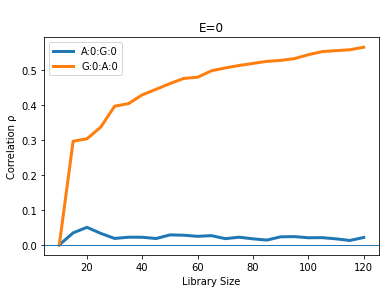

In [42]:
acc_data, acc_val, acc_time = next(gen_data_timedeltas(1, 1, Accelerometer_embed, 280, "A:x A:y A:z", real_data))
gyr_data, gyr_val, gyr_time = next(gen_data_timedeltas(1, 1, Gyroscope_embed, 280, "G:x G:y G:z", real_data))

acc_time = torch.vstack([acc_time, torch.zeros_like(acc_time)])
gyr_time = torch.vstack([gyr_time, torch.zeros_like(acc_time)])

acc_data, acc_time = acc_data.float(), acc_time.float()
gyr_data, gyr_time = gyr_data.float(), gyr_time.float()
gyr_val, acc_val = gyr_val.float(), acc_val.float()


Accelerometer_net.return_hidden = True
Gyroscope_net.return_hidden = True

device = torch.device("cpu")
Accelerometer_net = Accelerometer_net.to(device)
Gyroscope_net = Gyroscope_net.to(device)

_, accelerometer_h = Accelerometer_net(acc_data, acc_time)
_, gyroscope_h     = Gyroscope_net(gyr_data, gyr_time)

acc_h = np.array([accelerometer_h[i].squeeze().numpy() for i in range(len(accelerometer_h))])
gyr_h = np.array([gyroscope_h[i].squeeze().numpy() for i in range(len(gyroscope_h))])
time_ = acc_time.numpy()

data_ = pd.DataFrame(np.hstack( [time_[0].squeeze()[:-1].T[:, np.newaxis], acc_h[:-1], gyr_h[:-1]]) , columns = ['time', *[f"A:{i}" for i in range(10)], *[f"G:{i}" for i in range(10)]])

columns = ' '.join([f"A:{i}" for i in range(10)])
target =  ' '.join([f"G:{i}" for i in range(10)])
tmp = pyEDM.CCM(dataFrame = data_, columns = columns, target = target, embedded= True,libSizes="10 120 5", sample = 100, showPlot = True)

Корреляция при предсказании гироскопа в зависимости от данных акселерометра выросла

Ехуу